In [10]:
import torch
import torch.optim as optim

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchinfo import summary

from src.datasets import IrmaDataset
from src.transforms import MinMaxScaler, Sobel, Laplacian, GammaCorrection, HistogramEqualizer
from src.models import VAE, PVAE, PAE, ResidualVAE, ResidualPVAE
from src.utils.model_utils import train_val_split, get_latent, predict
from src.utils.visualization import (
    plot_reconstructions,
    plot_2d,
    sample_images,
    plot_history,
)
from src.utils.training_funcs import (
    train,
    validate,
    pred_loss,
    pred_reconstruction_loss,
    pred_kl_reconstruction_loss,
    kl_reconstruction_loss,
    get_metrics_str,
    pred_loss,
)

In [11]:
batch_size = 32
torch.backends.cudnn.benchmark = True

In [12]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            HistogramEqualizer(),
            Sobel(),
            HistogramEqualizer()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=69)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=69)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

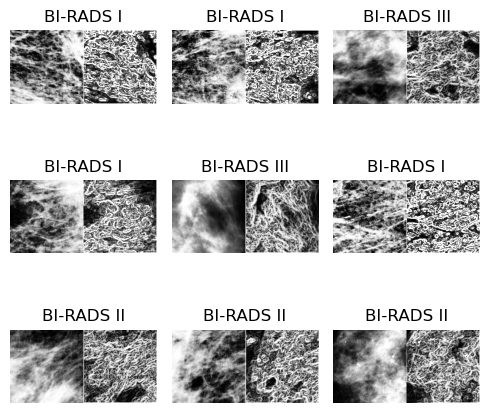

In [13]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=True)

In [15]:
rpVae = ResidualVAE(
    latent_dim=64,
    n_channels=2,
    conv_layers=[96, 64, 32, 16],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(16, 8, 8),
    linear_layers=[128, 64, 32],
    # pred_layers=[128, 64, 32, 16],
    # n_classes=4,
    use_batchnorm=True,
    dropout=0.15
)
summary(rpVae, (32, 2, 128, 128))

Layer (type:depth-idx)                        Output Shape              Param #
ResidualVAE                                   [32, 2, 128, 128]         --
├─ResidualEncoder: 1-1                        [32, 64]                  --
│    └─Sequential: 2-1                        [32, 16, 8, 8]            --
│    │    └─ResidualBlock: 3-1                [32, 96, 128, 128]        85,536
│    │    └─SiLU: 3-2                         [32, 96, 128, 128]        --
│    │    └─Downsample: 3-3                   [32, 96, 64, 64]          83,040
│    │    └─ResidualBlock: 3-4                [32, 64, 64, 64]          98,752
│    │    └─SiLU: 3-5                         [32, 64, 64, 64]          --
│    │    └─Downsample: 3-6                   [32, 64, 32, 32]          36,928
│    │    └─ResidualBlock: 3-7                [32, 32, 32, 32]          29,920
│    │    └─SiLU: 3-8                         [32, 32, 32, 32]          --
│    │    └─Downsample: 3-9                   [32, 32, 16, 16]          9,2

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(rpVae.parameters())
rpVae.to(device)

hist = train(rpVae, optimizer, dataloaders['train'], dataloaders['val'], 24, kl_reconstruction_loss)

[epoch: 1] train_loss: 11.7164 - train_rec_loss: 11.7018 - train_kl_loss: 0.0147 - val_loss: 9.3762 - val_rec_loss: 9.3487 - val_kl_loss: 0.0275
[epoch: 2] train_loss: 8.9224 - train_rec_loss: 8.8784 - train_kl_loss: 0.0440 - val_loss: 8.8067 - val_rec_loss: 8.7663 - val_kl_loss: 0.0404
[epoch: 3] train_loss: 8.6716 - train_rec_loss: 8.6266 - train_kl_loss: 0.0450 - val_loss: 8.7145 - val_rec_loss: 8.6739 - val_kl_loss: 0.0406
[epoch: 4] train_loss: 8.5711 - train_rec_loss: 8.5313 - train_kl_loss: 0.0398 - val_loss: 8.6375 - val_rec_loss: 8.5954 - val_kl_loss: 0.0421
[epoch: 5] train_loss: 8.4756 - train_rec_loss: 8.4360 - train_kl_loss: 0.0396 - val_loss: 8.6105 - val_rec_loss: 8.5595 - val_kl_loss: 0.0510
[epoch: 6] train_loss: 8.3776 - train_rec_loss: 8.3326 - train_kl_loss: 0.0450 - val_loss: 8.4809 - val_rec_loss: 8.4388 - val_kl_loss: 0.0421
[epoch: 7] train_loss: 8.2423 - train_rec_loss: 8.1962 - train_kl_loss: 0.0462 - val_loss: 8.4010 - val_rec_loss: 8.3627 - val_kl_loss: 0.03

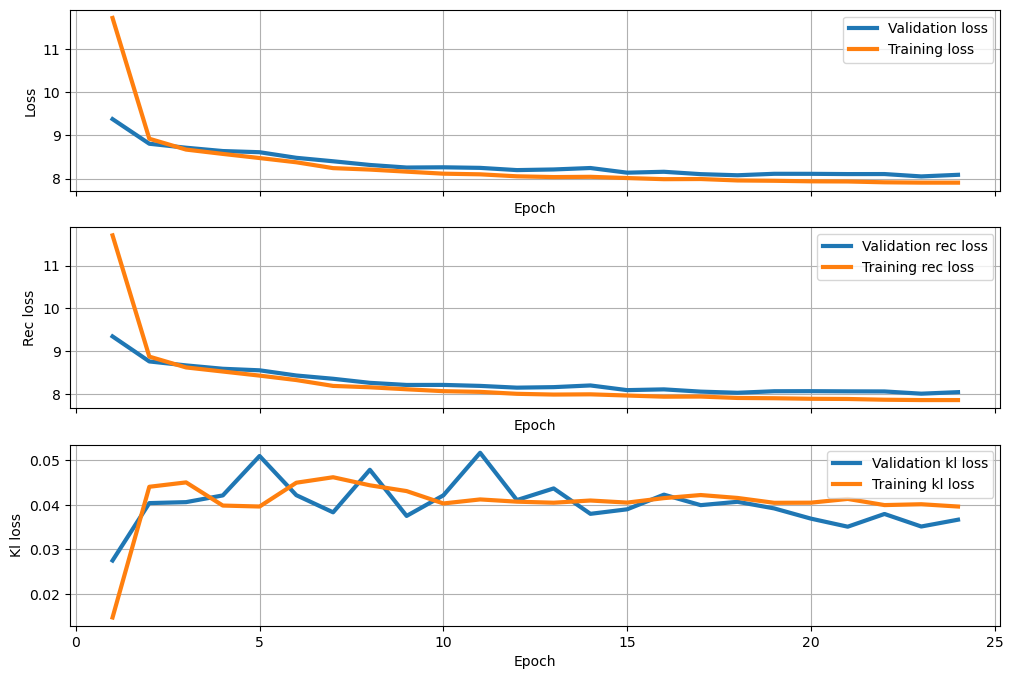

In [18]:
plot_history(hist)

In [19]:
# torch.save((pvae_64.kwargs ,pvae_64.state_dict()), "models/ablation/sobel/minMax/PVAE/model_bn.pt")

test_loss: 8.0491 - test_rec_loss: 8.0082 - test_kl_loss: 0.0409


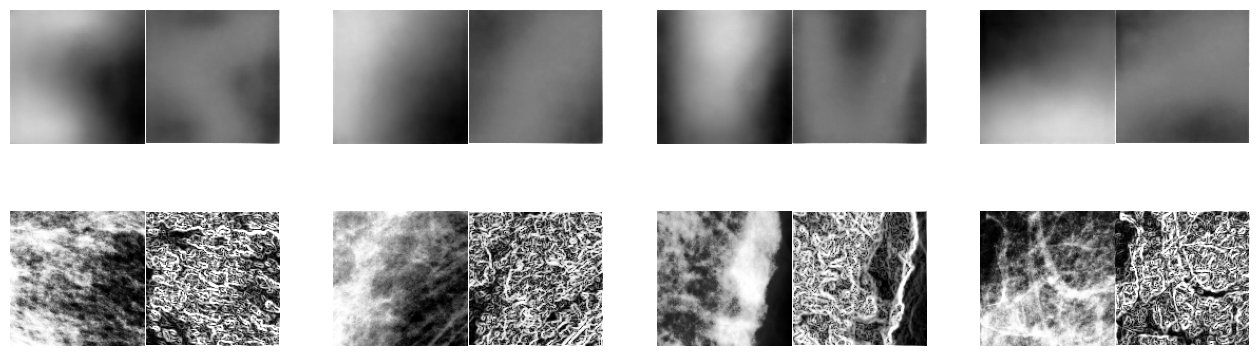

In [20]:
test_metrics = validate(rpVae, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(rpVae, dataloaders['test'], plot_borders=True)

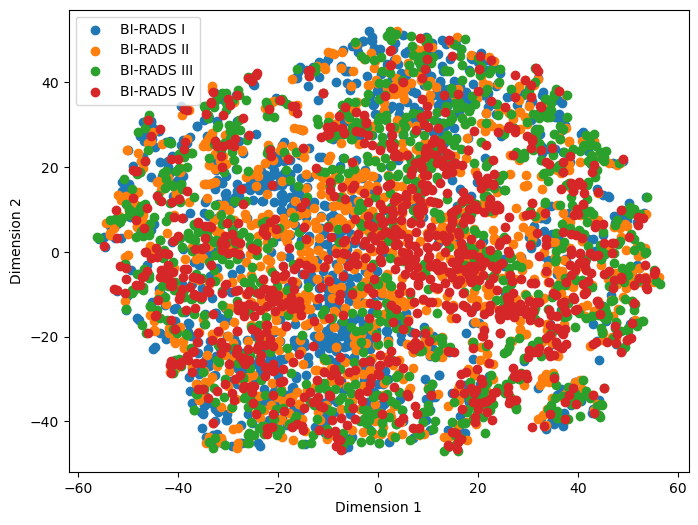

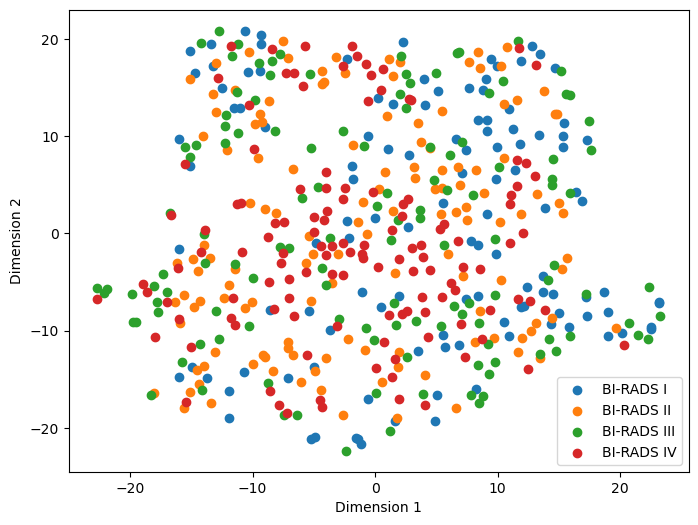

In [21]:
train_latent, train_labels = get_latent(rpVae, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(rpVae, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [22]:
train_latent, train_labels = get_latent(rpVae, dataloaders["train"])
val_latent, val_labels = get_latent(rpVae, dataloaders["val"])
latent, labels = get_latent(rpVae, dataloaders["test"])

In [23]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [24]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [25]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 8,320
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 82,756
Trainable params: 82,756
Non-trainable params: 0
Total mult-adds (M): 2.65
Input size (MB): 0.01
Forward/backward pass 

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3859 - train_predict_loss: 1.3859 - train_accuracy: 0.2740 - val_loss: 1.3852 - val_predict_loss: 1.3852 - val_accuracy: 0.3201
[epoch: 2] train_loss: 1.3846 - train_predict_loss: 1.3846 - train_accuracy: 0.3487 - val_loss: 1.3838 - val_predict_loss: 1.3838 - val_accuracy: 0.3519
[epoch: 3] train_loss: 1.3815 - train_predict_loss: 1.3815 - train_accuracy: 0.3748 - val_loss: 1.3800 - val_predict_loss: 1.3800 - val_accuracy: 0.3539
[epoch: 4] train_loss: 1.3734 - train_predict_loss: 1.3734 - train_accuracy: 0.3790 - val_loss: 1.3699 - val_predict_loss: 1.3699 - val_accuracy: 0.3539
[epoch: 5] train_loss: 1.3564 - train_predict_loss: 1.3564 - train_accuracy: 0.3808 - val_loss: 1.3543 - val_predict_loss: 1.3543 - val_accuracy: 0.3519
[epoch: 6] train_loss: 1.3381 - train_predict_loss: 1.3381 - train_accuracy: 0.3810 - val_loss: 1.3439 - val_predict_loss: 1.3439 - val_accuracy: 0.3638
[epoch: 7] train_loss: 1.3273 - train_predict_loss: 1.3273 - train_accuracy: 0.382

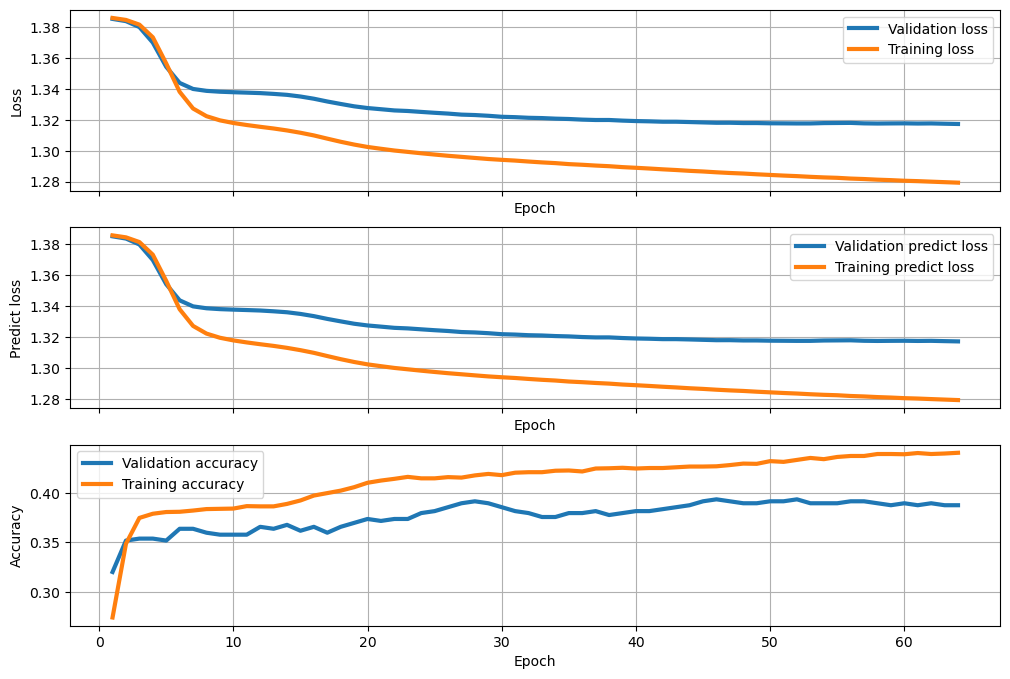

In [27]:
plot_history(hist)

In [28]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.3093 - test_predict_loss: 1.3093 - test_accuracy: 0.3956


In [29]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.63      0.48       118
           1       1.00      0.01      0.01       133
           2       0.33      0.43      0.38       126
           3       0.46      0.56      0.51       126

    accuracy                           0.40       503
   macro avg       0.55      0.40      0.34       503
weighted avg       0.56      0.40      0.34       503



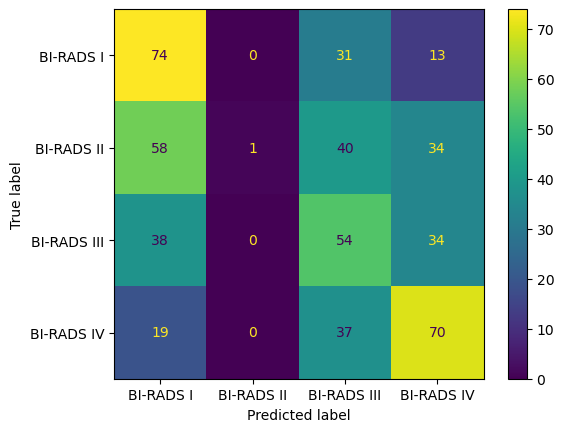

In [30]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()